# Packages

In [2]:
from os import getcwd as gwd
from os import chdir as cd
from itertools import combinations 
from scipy.stats import pearsonr as pr
from scipy.stats import zscore as zscore
from scipy.stats import ttest_rel as ttest
import copy
import numpy as np
import pandas
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib as plt
np.random.seed(223)

# Data

In [3]:
subjs = ['AN2','EW','IB','KH','MK','MY','NP']
dataAll = dict()
indcounter = 1
for subjName in subjs:
    data = pandas.read_csv((subjName+'.csv'),header=None,names=['cond','x','y','locs'],usecols=[13, 26, 27, 35])
    data = data[-pandas.isnull(data.x)] #delete the initial lines
    data = data[1:769] #take the rows we want
    data.index = range(768)
    data.cond[data.cond == 'womanmask.png'] = 1
    data.cond[data.cond == 'noisePatch.png'] = 2
    condarray = np.empty(768, dtype = np.int)
    condarray.fill(indcounter)
    data['ind'] = condarray
    indcounter += 1
    data = data.astype(float)
    dataAll[subjName] = data

In [4]:
dataAll['AN2']

,cond,x,y,locs,ind
0,1.0,-0.334549,-0.052747,73.0,1.0
1,1.0,0.335009,-0.048342,48.0,1.0
2,2.0,0.223459,-0.343859,40.0,1.0
3,2.0,-0.270573,-0.346350,31.0,1.0
4,1.0,0.272899,-0.136931,93.0,1.0
...,...,...,...,...,...
763,1.0,-0.290977,0.212096,67.0,1.0
764,2.0,0.075421,-0.296298,38.0,1.0
765,1.0,-0.014006,0.341997,60.0,1.0
766,2.0,-0.256411,0.230703,18.0,1.0


# Functions

In [5]:
#Calculate angular response
def calAng(x, y):
    angResp = np.rad2deg(np.arctan2(y,x))
    if angResp < 0:
        angResp += 360
    return angResp

#Morph errors---what exactly does this do???
def morphErr(err):
    if err > 180:
        err = -360+err
    else:
        if err < (-180):
            err = 360+err
    return err

#Replace outliers with mean
def clearOutliers(data):
    avg = np.mean(data, axis = None)
    sd = np.std(data, axis = None)
    out1 = np.nonzero(data < float(avg - 3*sd))
    out2 = np.nonzero(data > float(avg + 3*sd))
    if len(out1) != 0:
        data[out1] = avg
    if len(out2) != 0:
        data[out2] = avg
    return data


# Preprocessing

In [6]:
def prepersubj(data):
    angErr = None
    for trials in range(0, 768):
        err = morphErr(calAng(data.x[trials], data.y[trials]) - data.locs[trials]*7.5)
        if angErr is not None:
            angErr = np.vstack((angErr, np.array(err)))
        else:
            angErr = np.array(err)
    angErr = clearOutliers(angErr)
    return angErr

In [89]:
errAll = dict()
final = np.empty(96, dtype = np.int)
final.fill(1)
for counter in np.arange(2,9):
        array = np.empty(96, dtype = np.int)
        array.fill(counter)
        final = np.concatenate((final, array))
for subj in subjs:   
    errs = pandas.DataFrame(data = prepersubj(dataAll[subj]),columns=['errors'])
    errs['locs'] = dataAll[subj].locs
    errs['cond'] = dataAll[subj].cond
    errs['block'] = final
    errs.index = range(768)
    errAll[subj] = errs


In [91]:
FaceAll = dict()
for subj in subjs:
    face = errAll[subj].loc[errAll[subj]['cond'] == 1]
    face['locs'] = face['locs'] - 48
    face.index = range(384)
    FaceAll[subj] = face
    
NoiseAll = dict()
for subj in subjs:
    noise = errAll[subj].loc[errAll[subj]['cond'] == 2]
    noise.index = range(384)
    NoiseAll[subj] = noise

C:\Users\jerry\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Plots

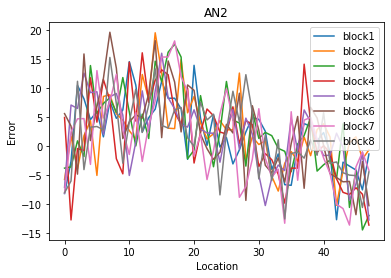

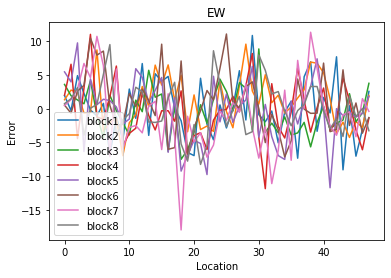

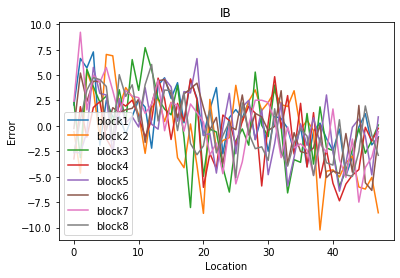

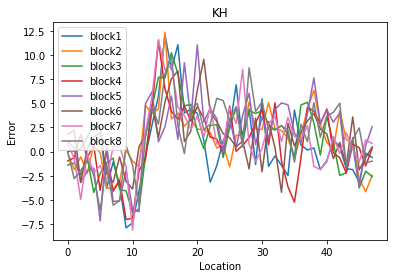

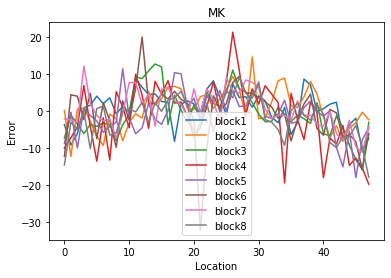

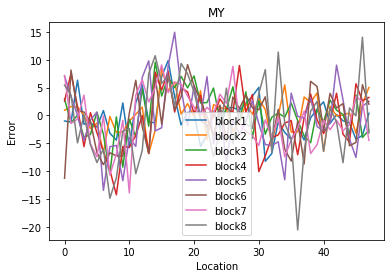

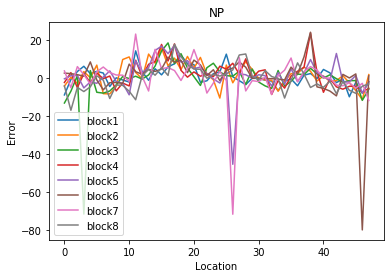

In [92]:
Face_p = dict()
for subj in subjs:
    f_table = pandas.DataFrame()
    f_table['block1'] = FaceAll[subj].loc[FaceAll[subj]['block'] == 1].sort_values(by = ['locs'], ignore_index = True).errors
    f_table['block2'] = FaceAll[subj].loc[FaceAll[subj]['block'] == 2].sort_values(by = ['locs'], ignore_index = True).errors
    f_table['block3'] = FaceAll[subj].loc[FaceAll[subj]['block'] == 3].sort_values(by = ['locs'], ignore_index = True).errors
    f_table['block4'] = FaceAll[subj].loc[FaceAll[subj]['block'] == 4].sort_values(by = ['locs'], ignore_index = True).errors
    f_table['block5'] = FaceAll[subj].loc[FaceAll[subj]['block'] == 5].sort_values(by = ['locs'], ignore_index = True).errors
    f_table['block6'] = FaceAll[subj].loc[FaceAll[subj]['block'] == 6].sort_values(by = ['locs'], ignore_index = True).errors
    f_table['block7'] = FaceAll[subj].loc[FaceAll[subj]['block'] == 7].sort_values(by = ['locs'], ignore_index = True).errors
    f_table['block8'] = FaceAll[subj].loc[FaceAll[subj]['block'] == 8].sort_values(by = ['locs'], ignore_index = True).errors
    Face_p[subj] = f_table
#subjs = ['AN2','EW','IB','KH','MK','MY','NP']
for subj in subjs:
    plot = Face_p[subj].plot()
    plot.set_xlabel('Location')
    plot.set_ylabel('Error')
    plot.set_title(subj)


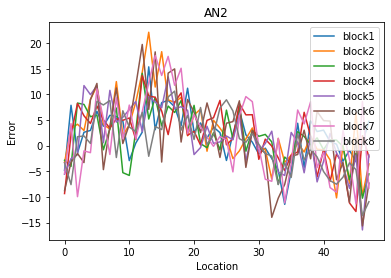

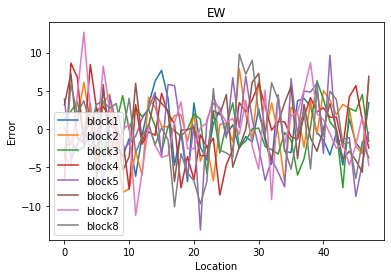

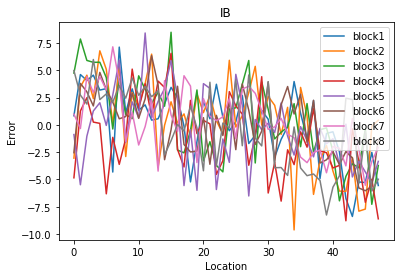

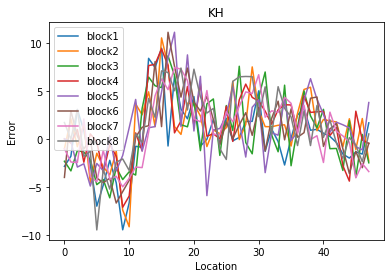

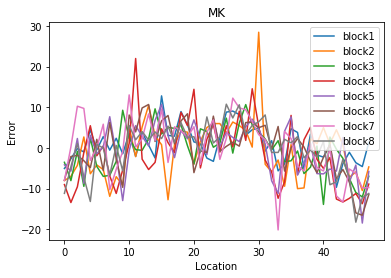

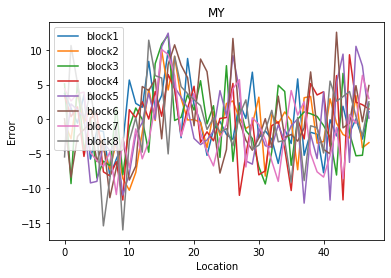

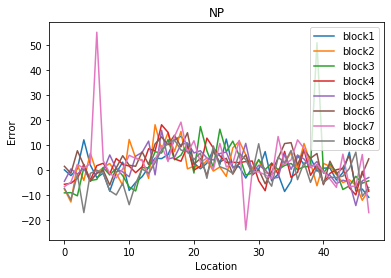

In [93]:
Noise_p = dict()
for subj in subjs:
    n_table = pandas.DataFrame()

    n_table['block1'] = NoiseAll[subj].loc[NoiseAll[subj]['block'] == 1].sort_values(by = ['locs'], ignore_index = True).errors
    n_table['block2'] = NoiseAll[subj].loc[NoiseAll[subj]['block'] == 2].sort_values(by = ['locs'], ignore_index = True).errors
    n_table['block3'] = NoiseAll[subj].loc[NoiseAll[subj]['block'] == 3].sort_values(by = ['locs'], ignore_index = True).errors
    n_table['block4'] = NoiseAll[subj].loc[NoiseAll[subj]['block'] == 4].sort_values(by = ['locs'], ignore_index = True).errors
    n_table['block5'] = NoiseAll[subj].loc[NoiseAll[subj]['block'] == 5].sort_values(by = ['locs'], ignore_index = True).errors
    n_table['block6'] = NoiseAll[subj].loc[NoiseAll[subj]['block'] == 6].sort_values(by = ['locs'], ignore_index = True).errors
    n_table['block7'] = NoiseAll[subj].loc[NoiseAll[subj]['block'] == 7].sort_values(by = ['locs'], ignore_index = True).errors
    n_table['block8'] = NoiseAll[subj].loc[NoiseAll[subj]['block'] == 8].sort_values(by = ['locs'], ignore_index = True).errors
    Noise_p[subj] = n_table
    
for subj in subjs:
    plot = Noise_p[subj].plot()
    plot.set_xlabel('Location')
    plot.set_ylabel('Error')
    plot.set_title(subj)